# Plusieurs modèles, données disjointes

On cherche à prédire la note d'un vin mais on suppose que cette qualité est dépendante de la couleur et qu'il faudrait appliquer des modèles différents selon la couleur.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## données

In [3]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()

In [4]:
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']
color = df['color']

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, color_train, color_test = train_test_split(X, y, color)

## version manuelle

On cale d'abord un modèle linéaire sur toute la base.

In [6]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X_train, y_train)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clr.predict(X_test))

0.48553846153846153

Et maintenant on essaye de caler un modèle différent selon les couleurs.

In [8]:
X_train_white = X_train[color_train == "white"]
y_train_white = y_train[color_train == "white"]
X_train_red = X_train[color_train == "red"]
y_train_red = y_train[color_train == "red"]

In [9]:
clr_white = LogisticRegression()
clr_white.fit(X_train, y_train)
clr_red = LogisticRegression()
clr_red.fit(X_train_red, y_train_red)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

LogisticRegression()

In [10]:
X_test_white = X_test[color_test == "white"]
y_test_white = y_test[color_test == "white"]
X_test_red = X_test[color_test == "red"]
y_test_red = y_test[color_test == "red"]

In [11]:
acc_white = accuracy_score(y_test_white, clr_white.predict(X_test_white))
acc_red = accuracy_score(y_test_red, clr_red.predict(X_test_red))
acc_white, acc_red

(0.4794745484400657, 0.5847665847665847)

Il faut agréger pour obtenir les performances sur la base complète.

In [12]:
acc2 = (acc_white * len(y_test_white) + acc_red * len(y_test_red)) / len(y_test)
acc2

0.5058461538461538

C'est un petit peu mieux mais l'ensemble est compliqué à mettre en place. Il serait plus simple d'automatiser pour pouvoir faire de la validation croisée.

## Automatisation

Au début, j'avais pensé écrire une classe inspirée de l'API de [scikit-learn](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/02_basic_of_machine_learning_with_scikit-learn.html#a-recap-on-scikit-learn-s-estimator-interface) qui apprend plusieurs modèles selon une catégorie indiquée lors de l'apprentissage et de la prédiction.

In [13]:
class SkBaseLearnerCategory:
    
    def fit(X, y, cat):
        # ...
        pass
        
    def predict(X, cat):
        # ...
        pass

Mais à moins de changer l'interface des [pipeline](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/pipeline.py#L290), il n'y aucun chance pour que cette classe puisse en faire partie. J'ai donc opté pour le design suivant même s'il ne me plaît que moyennement parce qu'il faut gérer plusieurs containers différents (numpy, pandas, ...)

In [14]:
class SkBaseLearnerCategory:
    
    def __init__(cat="column"):
        self.cat_col = cat
        pass
    
    def fit(X, y, cat):
        X = X.drop(self.cat_col, axis=1)
        # ...
                
    def predict(X, cat):
        X = X.drop(self.cat_col, axis=1)
        # ...

Bref, ça marche...

In [15]:
from papierstat.mltricks import SkBaseLearnerCategory
import pandas
model = SkBaseLearnerCategory("color", LogisticRegression())
new_x_train = pandas.concat([X_train, color_train], axis=1)
model.fit(new_x_train, y_train)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

SkBaseLearnerCategory(LogisticRegression(),colnameind='color')

In [16]:
new_x_test = pandas.concat([X_test, color_test], axis=1)
accuracy_score(y_test, model.predict(new_x_test))

0.5083076923076923

## Exemple sur un jeu articificiel

Comme ce n'est pas très probant... Essayons de vérifier que l'implémentation est correcte en fabriquant un jeu de données où cela doit marcher.

In [17]:
import numpy
n = 20
colorart = numpy.array([0 for i in range(0,n)] + [1 for i in range(0,n)])
Xart = numpy.random.random(n*2)
Xart = Xart[:, numpy.newaxis]
Yart = Xart.ravel() + colorart + numpy.random.random(n*2)/10

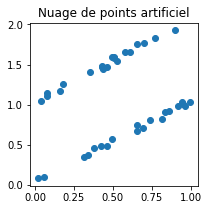

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.plot(Xart, Yart, 'o')
ax.set_title("Nuage de points artificiel");

On apprend une régression linéaire.

In [19]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(Xart, Yart)
pred = reg.predict(Xart)

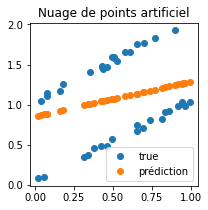

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.plot(Xart, Yart, 'o', label="true")
ax.plot(Xart, pred, 'o', label="prédiction")
ax.set_title("Nuage de points artificiel")
ax.legend();

Le jeu a été construit pour échouer. Voyons avec les couleurs.

In [21]:
new_x_art = pandas.DataFrame(dict(X=Xart.ravel(), color=colorart))

In [22]:
model = SkBaseLearnerCategory("color", LinearRegression())
model.fit(new_x_art, Yart)
pred2 = model.predict(new_x_art)

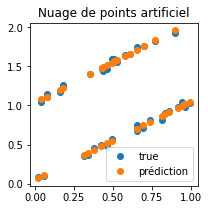

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.plot(Xart, Yart, 'o', label="true")
ax.plot(Xart, pred2, 'o', label="prédiction")
ax.set_title("Nuage de points artificiel")
ax.legend();

L'implémentation fonctionne. Donc cela n'ajoute rien de caler un modèle différent sur vins rouges et blancs s'il est linéaire. Essaysons avec un autre.

In [24]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
acc1 = accuracy_score(y_test, model.predict(X_test))

model = SkBaseLearnerCategory("color", DecisionTreeClassifier())
model.fit(new_x_train, y_train)
acc2 = accuracy_score(y_test, model.predict(new_x_test))

acc1, acc2

(0.6055384615384616, 0.5907692307692308)

C'est légèrement mieux mais cela varie dès qu'on exécute plusieurs fois. A vérifier avec une validation croisée.

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
acc1 = accuracy_score(y_test, model.predict(X_test))

model = SkBaseLearnerCategory("color", RandomForestClassifier())
model.fit(new_x_train, y_train)
acc2 = accuracy_score(y_test, model.predict(new_x_test))

acc1, acc2

(0.6775384615384615, 0.6701538461538461)

Ici cela n'apporte rien du tout.

In [26]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
# generate some data to play with
X, y = make_classification(n_informative=5, n_redundant=0, random_state=42)
# ANOVA SVM-C
anova_filter = SelectKBest(f_regression, k=5)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])    
anova_svm.fit(X, y)

Pipeline(steps=[('anova',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001906FEF9EE0>)),
                ('svc', SVC(kernel='linear'))])